In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import polyan

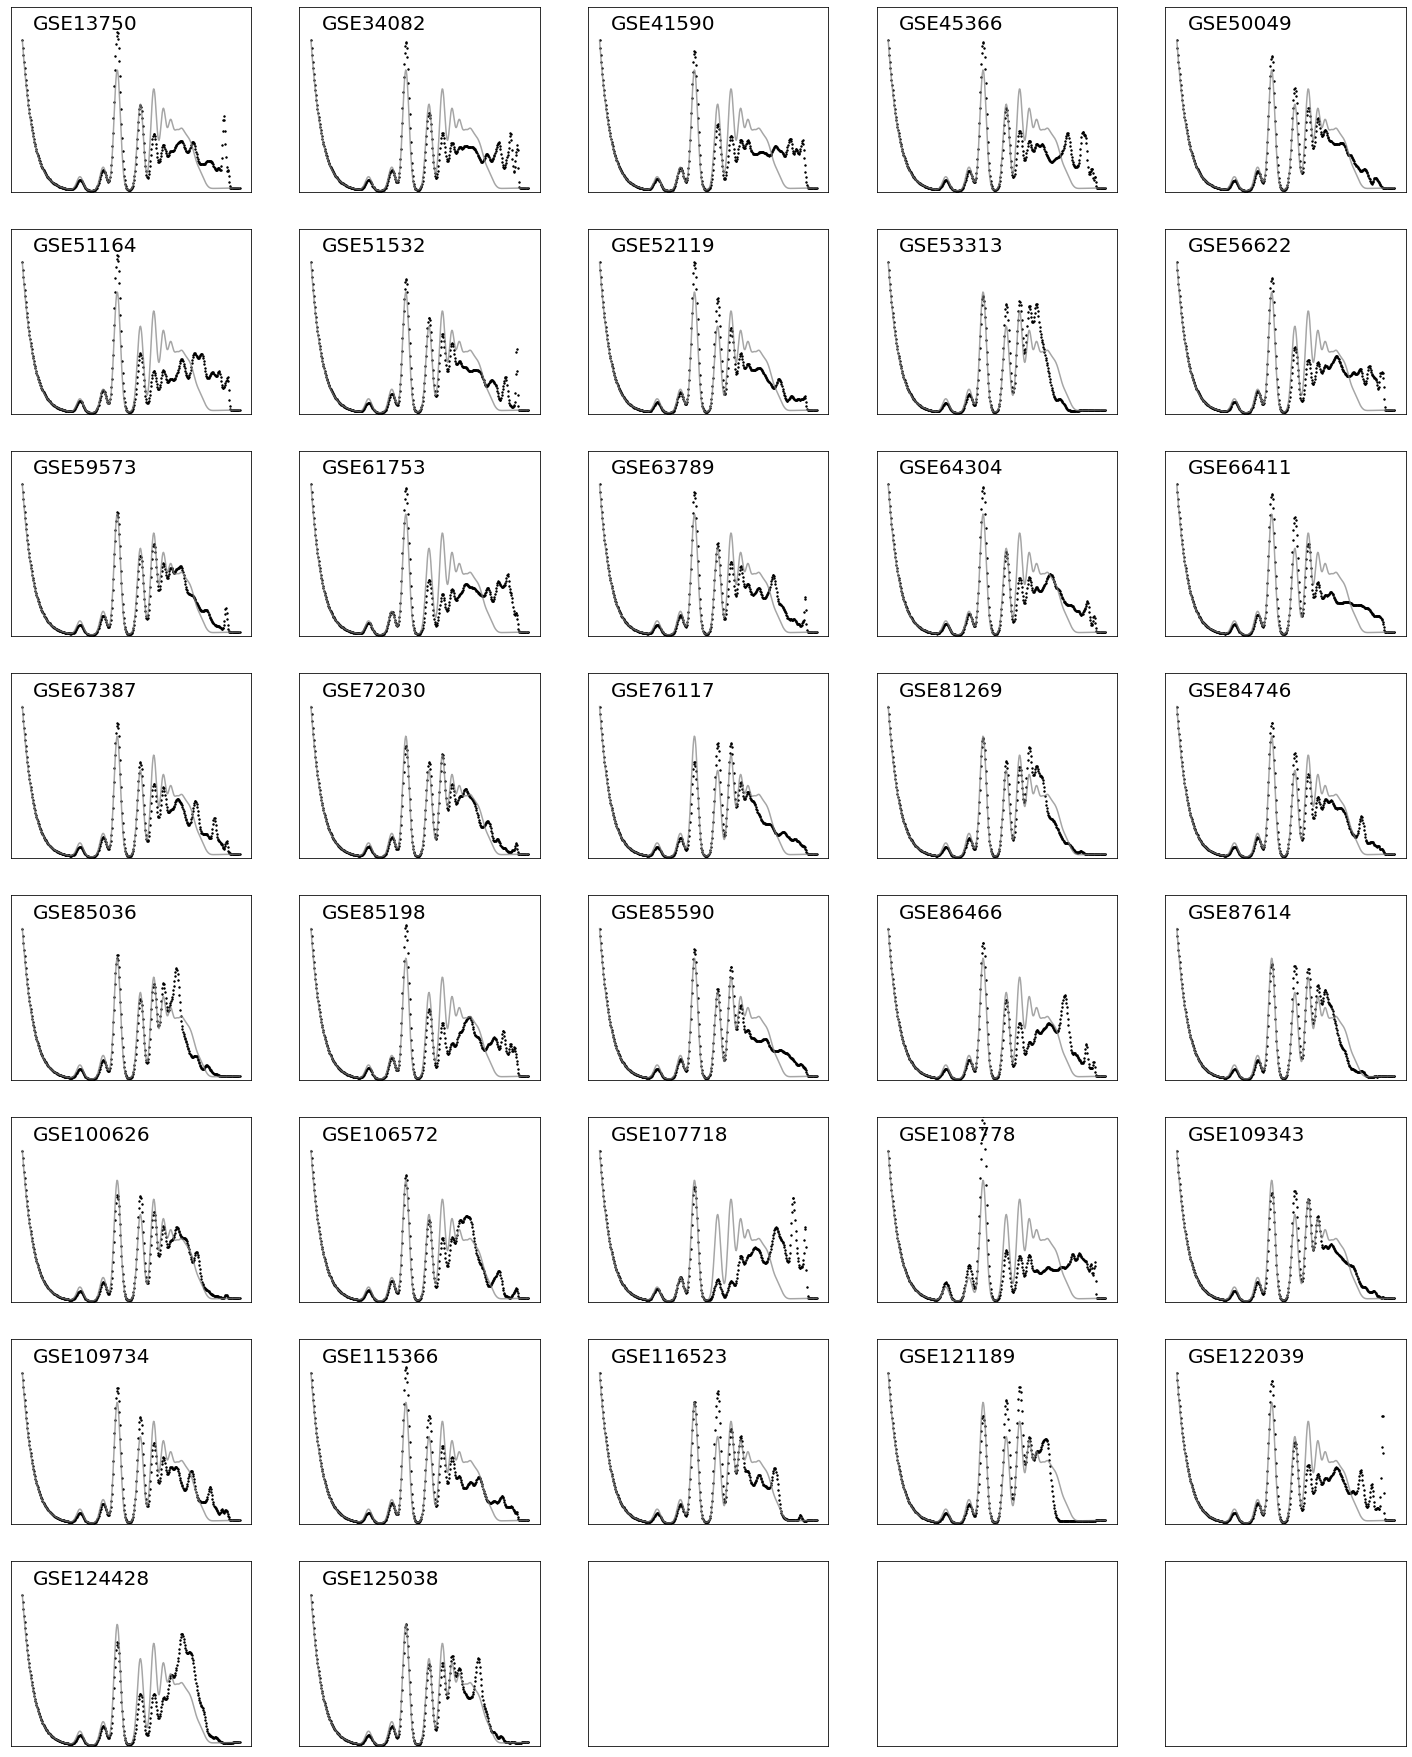

In [2]:
#load dataset names
datasets = pd.read_csv('Data/yeast_datasets.csv')
files = list(datasets['SeriesID'])

#define a reference profile based on a representative polysome experimental profile
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = polyan.plot_poly(ref_peaks)

#calculate the polysome profiles corresponding to the individual accessions
poly_vols = []
for file in files:
    dataset = pd.read_csv('Data/' + file + '.csv')
    try:
        poly_vols.append(polyan.fp2poly(dataset))
    except:
        poly_vols.append(polyan.fp2poly(dataset,has_RNA=False))
    
#plot the results    
fig,ax = plt.subplots(8,5,figsize=(25,32))
for trace_no in range(len(poly_vols)):
    row = int(trace_no / 5)
    col = int(trace_no - (5 * row))
    x,y = polyan.plot_poly(poly_vols[trace_no])
    ax[row][col].plot(x_ref,y_ref,c='grey',alpha=0.7)
    ax[row][col].scatter(x,y,s=2,c='black')
    ax[row][col].set_yticks([])
    ax[row][col].set_ylim((0,8))
    ax[row][col].set_xticks([])
    ax[row][col].text(0.05,7,files[trace_no],fontsize=20)
for col_no in range(5-col):
    ax[row][col+col_no].set_xticks([])
    ax[row][col+col_no].set_yticks([])
plt.savefig('Supp Figure 3.pdf')
plt.show()